In [ ]:
#mainly based based on https://github.com/Diyago/ML-DL-scripts/tree/master/DEEP%20LEARNING/segmentation/Segmentation%20pipeline

In [ ]:
HOME = r"/content/drive/MyDrive/gather/ML-DL-scripts/DEEP LEARNING/segmentation/Segmentation pipeline"
req_file = (HOME + r"/requirementstf1.15V3.txt")
print(req_file)
#!pip install -r "$req_file"   --use-deprecated=legacy-resolver  #if needed install packages

#Preparing Libraries and Folders

In [ ]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
import os
os.chdir(HOME)

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
#from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from model_training import *
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from keras.models import load_model
tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (
    Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss,
                           IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion
                            )
 
#import albumentations as albu
from albumentations import Resize

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
#first: create folders 
!mkdir road_segmentation/training
!mkdir road_segmentation/training/input
!mkdir road_segmentation/training/output
!mkdir road_segmentation/testing
!mkdir road_segmentation/testing/input
!mkdir road_segmentation/testing/output

mkdir: cannot create directory ‘road_segmentation/training’: File exists
mkdir: cannot create directory ‘road_segmentation/training/input’: File exists
mkdir: cannot create directory ‘road_segmentation/training/output’: File exists
mkdir: cannot create directory ‘road_segmentation/testing’: File exists
mkdir: cannot create directory ‘road_segmentation/testing/input’: File exists
mkdir: cannot create directory ‘road_segmentation/testing/output’: File exists


In [ ]:
#download images
!python "get dataset.py"

skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped


## Defining data generator

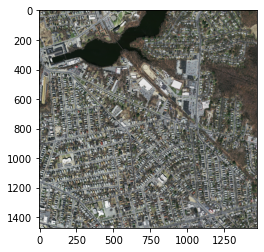

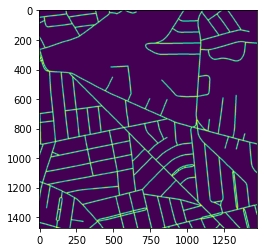

In [ ]:
#try reading images:
test_generator = DataGeneratorFolder(root_dir = './road_segmentation/training',#'./data/road_segmentation_ideal/training',
                                     image_folder = 'input/', 
                                     mask_folder = 'output/',
                                     batch_size = 1,
                                     nb_y_features = 1, 
                                     #augmentation = aug_with_crop
                                     )
Xtest, ytest = test_generator.__getitem__(0)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show() 

In [ ]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = './road_segmentation/testing', #root_dir = './data/road_segmentation_ideal/training', 
                           image_folder = 'input/', 
                           mask_folder = 'output/', 
                                   batch_size=1,augmentation = aug_with_crop,
                                   nb_y_features = 1#, augmentation = True
                                   )



batch_size = 4 #maybe change

train_generator = DataGeneratorFolder(root_dir = './road_segmentation/training', 
                                      image_folder = 'input/', 
                                      mask_folder = 'output/', 
                                      augmentation = aug_with_crop,
                                      batch_size= batch_size,
                                      image_size=512,
                                      nb_y_features = 1#,
                                      #augmentation = True
                                      )

## Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/road_crop.efficientnetb0imgsize.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [ ]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    
model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
model.compile(optimizer = Adam(),
                    loss=bce_jaccard_loss, metrics=[iou_score])
TRAIN_AGAIN = True
if TRAIN_AGAIN:    
  history = model.fit_generator(train_generator, shuffle =True,
                    epochs=3, workers=30, use_multiprocessing=True,
                    validation_data = test_generator, 
                    verbose = 1, callbacks=callbacks)  
  plot_training_history(history)
  model.save("model_short.h5")
else:
  model = load_model('model_short.h5', compile=False)
  


## Inference and model quality  check

#### Single image

In [ ]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Blues")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

# to get single image and prediction quality
Xtest, y_test  = test_generator.__getitem__(1)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(768, 768)
print('IOU', iou_metric(y_test[0].reshape(768, 768), predicted))
#predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(1472, 1472)
#print('IOU', iou_metric(y_test[0].reshape(1472, 1472), predicted)) 

IOU [[0.5229301]]


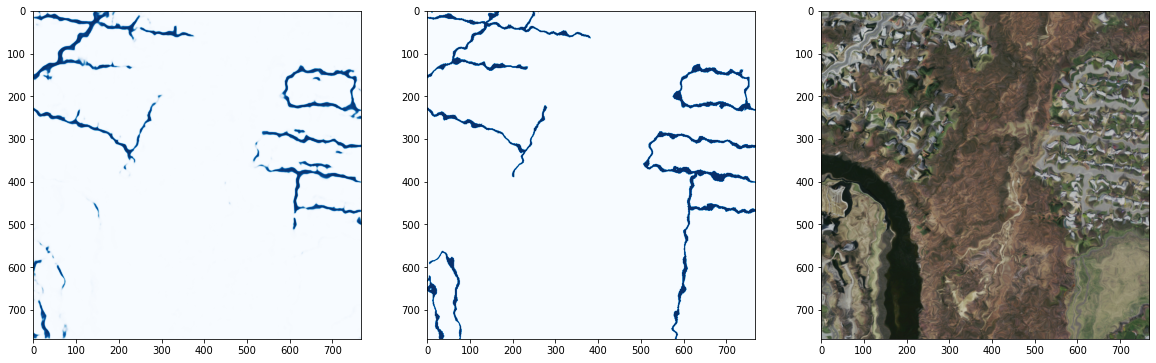

In [ ]:
plot_mask_gt_image(predicted, y_test.squeeze(0).squeeze(-1),\
           Xtest.squeeze(0))

### By adjusting threshold you can further improve your score

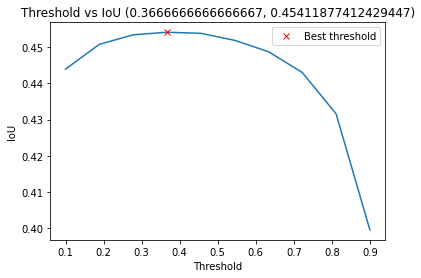

In [ ]:
def draw_get_best_threshold(ious, thresholds):
    """
    Returns threshold_best, iou_best
    """
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    return threshold_best, iou_best

preds = []
y_val = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    #preds.append(model.predict(Xtest).reshape(1472, 1472))
    preds.append(model.predict(Xtest).reshape(768, 768))
   
    
    #preds.append(tta_model.predict(Xtest).reshape(1472, 1472))
    y_val.append(y_test)
preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

thresholds = list(np.linspace(0.1, 0.9, 10))
ious = np.array([iou_metric_batch(y_val, np.int32(preds > threshold)) for threshold in (thresholds)])

best_threshold, best_iou = draw_get_best_threshold(ious, thresholds)

# Applying the trained model to Madagascar data

In [ ]:
def read_madagascar_image(image_name):
  this_batch_size = 1
  X = np.empty((this_batch_size, train_generator.image_size, train_generator.image_size, 3), dtype=np.float32)
  X_sample =  (imread(image_name)/255).astype("float32")
  augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = None)
  X_sample = augmented['image']

  return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32)

Xm = read_madagascar_image("madagascar.tif")


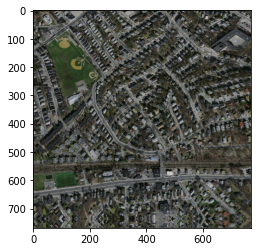

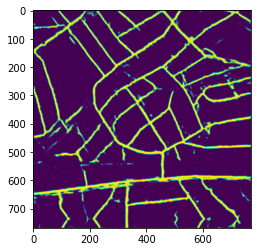

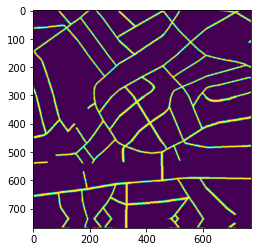

In [ ]:
#comparing with (predicted) training data
Xtest2, ytest2  = test_generator.__getitem__(2)
ypred2 = model.predict(Xtest2)
plt.imshow(Xtest2[0])
plt.show()
plt.imshow(ypred2[0, :,:,0])     
plt.show()
plt.imshow(ytest2[0, :,:,0])
plt.show() 